In [125]:
import numpy as np
import networkx as nx
import osmnx as ox
import os
import glob
from infomap import Infomap
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import LineString
from scipy.linalg import eig
import seaborn as sns
import statsmodels.api as sm

# Read data

In [106]:
# Read graphml files for cities
city_graph_dict = {}

files = glob.glob('../input/data/*.graphml')
for file in files:
    filename = os.path.basename(file)
    city = filename.split('_')[0]
    graph = ox.io.load_graphml(file)
    city_graph_dict[city] = graph

In [107]:
city_graph_dict

{'johannesburg': <networkx.classes.multidigraph.MultiDiGraph at 0x370a7ecb0>,
 'lyon': <networkx.classes.multidigraph.MultiDiGraph at 0x371381d10>,
 'sarajevo': <networkx.classes.multidigraph.MultiDiGraph at 0x3719ec4b0>,
 'jakarta': <networkx.classes.multidigraph.MultiDiGraph at 0x3716b3c50>,
 'glasgow': <networkx.classes.multidigraph.MultiDiGraph at 0x371f18230>,
 'dubai': <networkx.classes.multidigraph.MultiDiGraph at 0x370937070>,
 'lisbon': <networkx.classes.multidigraph.MultiDiGraph at 0x370937390>,
 'london': <networkx.classes.multidigraph.MultiDiGraph at 0x3707bb9d0>,
 'lagos': <networkx.classes.multidigraph.MultiDiGraph at 0x3707bbe30>,
 'charlotte': <networkx.classes.multidigraph.MultiDiGraph at 0x367a3acb0>,
 'vienna': <networkx.classes.multidigraph.MultiDiGraph at 0x32baff4d0>,
 'copenhagen': <networkx.classes.multidigraph.MultiDiGraph at 0x3711411d0>,
 'shanghai': <networkx.classes.multidigraph.MultiDiGraph at 0x3667c4d70>,
 'lima': <networkx.classes.multidigraph.MultiDiGr

In [108]:
# Convert graphs to undirected
city_graph_dict_undirected = {}
for city, G in city_graph_dict.items():
    city_graph_dict_undirected[city] = G.to_undirected()

# Run infomap and analyze communities

## Directed graph

In [132]:
# Run infomap on each graph and store the communities
city_communities_dict = {}
for city, G in tqdm(city_graph_dict.items()):
    # # Choose flags explicitly
    # im = Infomap("--two-level --num-trials 50")
    # If your graph is directed, use:
    im = Infomap("--directed --two-level --num-trials 50")
    
    # Map NetworkX node labels to integers (REQUIRED)
    node_to_id = {node: i for i, node in enumerate(G.nodes())}
    id_to_node = {i: node for node, i in node_to_id.items()}

    # Add edges
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        im.addLink(node_to_id[u], node_to_id[v], w)

    # Run Infomap
    im.run()

    # Extract communities
    communities = {}
    for node in im.nodes:
        original_node = id_to_node[node.node_id]
        communities[original_node] = node.module_id

    city_communities_dict[city] = communities
    nx.set_node_attributes(G, communities, "infomap")

# communities: dict {node -> community_id}

100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


## Undirected graph

In [133]:
# Run infomap on each graph and store the communities
city_communities_undirected_dict = {}
for city, G in tqdm(city_graph_dict_undirected.items()):
    # Choose flags explicitly
    im = Infomap("--two-level --num-trials 50")
    # If your graph is directed, use:
    # im = Infomap("--directed --two-level --num-trials 50")
    
    # Map NetworkX node labels to integers (REQUIRED)
    node_to_id = {node: i for i, node in enumerate(G.nodes())}
    id_to_node = {i: node for node, i in node_to_id.items()}

    # Add edges
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        im.addLink(node_to_id[u], node_to_id[v], w)

    # Run Infomap
    im.run()

    # Extract communities
    communities = {}
    for node in im.nodes:
        original_node = id_to_node[node.node_id]
        communities[original_node] = node.module_id

    city_communities_undirected_dict[city] = communities
    nx.set_node_attributes(G, communities, "infomap")

# communities: dict {node -> community_id}

100%|██████████| 32/32 [00:10<00:00,  3.17it/s]


## Visualize communities

### Plot infomap communities onto the road network

In [134]:
def plot_infomap_edges(G, comm, axes, black="#eeeeee", cmap_name="tab20"):
    """
    G: osmnx graph (usually MultiDiGraph)
    comm: dict {node_id: community_id}
    """

    # stable list of community ids and a color map for them
    comm_ids = sorted(set(comm.values()))
    cmap = plt.get_cmap(cmap_name, max(len(comm_ids), 1))
    comm_to_color = {cid: mpl.colors.to_hex(cmap(i)) for i, cid in enumerate(comm_ids)}

    edge_colors = []
    for u, v, k, data in G.edges(keys=True, data=True):
        cu = comm.get(u, None)
        cv = comm.get(v, None)

        if (cu is not None) and (cv is not None) and (cu == cv):
            edge_colors.append(comm_to_color[cu])
        else:
            edge_colors.append(black)

    fig, ax = ox.plot_graph(
        G,
        node_size=0,                 # streets only
        edge_color=edge_colors,
        edge_linewidth=1.2,
        edge_alpha=1.0,
        bgcolor="white",
        show=False,
        close=False,
        ax=axes,
    )

    return fig, ax

# usage:
# fig, ax = plot_infomap_edges(G, communities_dict)
# plt.show()


### Plot infomap communities with edges

In [ ]:
# def plot_infomap_edges_oneway(
#     G,
#     comm,
#     axes,
#     black="#eeeeee",
#     cmap_name="tab20",
#     edge_linewidth=1.2,
#     arrow_size=10,
#     arrow_alpha=0.9,
#     arrows_every=1,      # increase (e.g., 3) to reduce clutter
# ):
#     """
#     Colors within-community edges by community color, cross-community edges in `black`,
#     and overlays arrows for one-way streets (edges lacking a reciprocal edge).
#     """

#     # community -> color
#     comm_ids = sorted(set(comm.values()))
#     cmap = plt.get_cmap(cmap_name, max(len(comm_ids), 1))
#     comm_to_color = {cid: mpl.colors.to_hex(cmap(i)) for i, cid in enumerate(comm_ids)}

#     # IMPORTANT: build edge list once; reuse order for colors and arrows
#     edges = list(G.edges(keys=True, data=True))

#     edge_colors = []
#     for u, v, k, data in edges:
#         cu = comm.get(u, None)
#         cv = comm.get(v, None)
#         if (cu is not None) and (cv is not None) and (cu == cv):
#             edge_colors.append(comm_to_color[cu])
#         else:
#             edge_colors.append(black)

#     # base plot (uses caller-provided axes)
#     fig, ax = ox.plot_graph(
#         G,
#         node_size=0,
#         edge_color=edge_colors,
#         edge_linewidth=edge_linewidth,
#         edge_alpha=1.0,
#         bgcolor="white",
#         show=False,
#         close=False,
#         ax=axes,
#     )

#     def edge_geom(u, v, data):
#         # OSMnx edges often have a shapely LineString geometry
#         geom = data.get("geometry", None)
#         if geom is not None:
#             return geom
#         # fallback: straight segment between nodes
#         x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
#         x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
#         return LineString([(x1, y1), (x2, y2)])
    
#     # draw thicker lines for one-way edges
#     for idx, (u, v, k, data) in enumerate(edges):
#         if G.has_edge(v, u):  # two-way, skip
#             continue

#         geom = data.get("geometry", None)
#         if geom is None:
#             x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
#             x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
#             ax.plot([x1, x2], [y1, y2],
#                     color=edge_colors[idx],
#                     linewidth=edge_linewidth * 2.2,   # <-- thicker
#                     alpha=1.0,
#                     zorder=3)
#         else:
#             xs, ys = geom.xy
#             ax.plot(xs, ys,
#                     color=edge_colors[idx],
#                     linewidth=edge_linewidth * 2.2,   # <-- thicker
#                     alpha=1.0,
#                     zorder=3)

#     # overlay arrows on one-way edges: u->v exists but v->u does not
#     drawn = 0
#     for idx, (u, v, k, data) in enumerate(edges):
#         if G.has_edge(v, u):   # reciprocal exists => effectively two-way
#             continue

#         # optional decimation to reduce clutter
#         if arrows_every > 1 and (drawn % arrows_every) != 0:
#             drawn += 1
#             continue

#         geom = edge_geom(u, v, data)
#         if geom.length == 0:
#             drawn += 1
#             continue

#         # place a small arrow along the edge geometry
#         p0 = geom.interpolate(0.45, normalized=True)
#         p1 = geom.interpolate(0.55, normalized=True)

#         ax.annotate(
#             "",
#             xy=(p1.x, p1.y),
#             xytext=(p0.x, p0.y),
#             arrowprops=dict(
#                 arrowstyle="-|>",
#                 mutation_scale=arrow_size,
#                 color=edge_colors[idx],  # match the edge's color
#                 lw=0,
#             ),
#             alpha=arrow_alpha,
#         )
#         drawn += 1

#     return fig, ax


In [155]:
def plot_infomap_edges_oneway(
    G,
    comm,
    axes,
    black="#eeeeee",
    cmap_name="tab20",
    edge_linewidth=1.2,
    arrow_size=10,
    arrow_alpha=0.9,
    arrows_every=1,

    # --- new: stationary distribution overlay ---
    show_stationary=True,
    stationary_method="pagerank",   # "pagerank" (recommended) or "eig"
    alpha_pr=0.85,                  # used if stationary_method="pagerank"
    node_cmap="viridis",
    node_size_range=(5, 120),       # (min_size, max_size) in points^2
    node_alpha_range=(0.15, 0.95),  # (min_alpha, max_alpha)
    add_colorbar=True,
):
    """
    Colors within-community edges by community color, cross-community edges in `black`,
    overlays arrows for one-way streets, and optionally overlays stationary probabilities
    as node markers.
    """

    # community -> color
    comm_ids = sorted(set(comm.values()))
    cmap = plt.get_cmap(cmap_name, max(len(comm_ids), 1))
    comm_to_color = {cid: mpl.colors.to_hex(cmap(i)) for i, cid in enumerate(comm_ids)}

    # IMPORTANT: build edge list once; reuse order for colors and arrows
    edges = list(G.edges(keys=True, data=True))

    edge_colors = []
    for u, v, k, data in edges:
        cu = comm.get(u, None)
        cv = comm.get(v, None)
        if (cu is not None) and (cv is not None) and (cu == cv):
            edge_colors.append(comm_to_color[cu])
        else:
            edge_colors.append(black)

    # base plot (uses caller-provided axes)
    fig, ax = ox.plot_graph(
        G,
        node_size=0,
        edge_color=edge_colors,
        edge_linewidth=edge_linewidth,
        edge_alpha=1.0,
        bgcolor="white",
        show=False,
        close=False,
        ax=axes,
    )

    def edge_geom(u, v, data):
        geom = data.get("geometry", None)
        if geom is not None:
            return geom
        x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
        x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
        return LineString([(x1, y1), (x2, y2)])

    # draw thicker lines for one-way edges
    for idx, (u, v, k, data) in enumerate(edges):
        if G.has_edge(v, u):
            continue

        geom = data.get("geometry", None)
        if geom is None:
            x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
            x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
            ax.plot([x1, x2], [y1, y2],
                    color=edge_colors[idx],
                    linewidth=edge_linewidth * 2.2,
                    alpha=1.0,
                    zorder=3)
        else:
            xs, ys = geom.xy
            ax.plot(xs, ys,
                    color=edge_colors[idx],
                    linewidth=edge_linewidth * 2.2,
                    alpha=1.0,
                    zorder=3)

    # overlay arrows on one-way edges
    drawn = 0
    for idx, (u, v, k, data) in enumerate(edges):
        if G.has_edge(v, u):
            continue

        if arrows_every > 1 and (drawn % arrows_every) != 0:
            drawn += 1
            continue

        geom = edge_geom(u, v, data)
        if geom.length == 0:
            drawn += 1
            continue

        p0 = geom.interpolate(0.45, normalized=True)
        p1 = geom.interpolate(0.55, normalized=True)

        ax.annotate(
            "",
            xy=(p1.x, p1.y),
            xytext=(p0.x, p0.y),
            arrowprops=dict(
                arrowstyle="-|>",
                mutation_scale=arrow_size,
                color=edge_colors[idx],
                lw=0,
            ),
            alpha=arrow_alpha,
            zorder=4,
        )
        drawn += 1

    # -------------------------
    # NEW: stationary overlay
    # -------------------------
    if show_stationary:
        # Choose a robust stationary distribution for directed street graphs:
        # PageRank gives you a unique stationary-like distribution even with sinks.
        if stationary_method == "pagerank":
            G = ox.utils_graph.get_digraph(G)  # ensures DiGraph view for some ops
            # networkx pagerank works on DiGraph/MultiDiGraph; keep it simple:
            pr = nx.pagerank(G, alpha=alpha_pr, weight="weight")  # dict node->prob
            stat = pr
            # print(f'Stationary distribution: {stat}')
            # print(f'Sum of stationary probabilities: {sum(stat.values())}')

        elif stationary_method == "eig":
            # pure random-walk stationary distribution: requires ergodic chain
            # builds P from edge weights if present else 1.0
            nodes = list(G.nodes())
            idx = {n: i for i, n in enumerate(nodes)}
            n = len(nodes)
            P = np.zeros((n, n), dtype=float)

            # for u, v, k, data in G.edges(keys=True, data=True):
            #     w = float(data.get("weight", 1.0))
            #     P[idx[u], idx[v]] += w
            # inside your stationary_method == "eig" build:
            for u, v, k, data in G.edges(keys=True, data=True):
                w = float(data.get("weight", 1.0))
                P[idx[u], idx[v]] += w
                if not G.is_directed():
                    P[idx[v], idx[u]] += w


            row_sums = P.sum(axis=1)
            # avoid divide by zero (dangling nodes) -> leave row zeros
            nz = row_sums > 0
            P[nz] = P[nz] / row_sums[nz][:, None]

            # power iteration
            x = np.ones(n) / n
            for _ in range(1000):
                x_new = x @ P
                if np.linalg.norm(x_new - x, 1) < 1e-12:
                    break
                x = x_new
            stat = {nodes[i]: float(x[i]) for i in range(n)}
            # print(f'Stationary distribution: {stat}')
            # print(f'Sum of stationary probabilities: {sum(stat.values())}')

        else:
            raise ValueError("stationary_method must be 'pagerank' or 'eig'")

        # extract coordinates in node order
        nodes = list(G.nodes())
        xs = np.array([G.nodes[n]["x"] for n in nodes], dtype=float)
        ys = np.array([G.nodes[n]["y"] for n in nodes], dtype=float)
        vals = np.array([stat.get(n, 0.0) for n in nodes], dtype=float)

        # scale sizes (log helps when distribution is very skewed)
        # use log1p so zeros are ok
        v = np.log1p(vals)
        if np.all(v == v[0]):
            vmin, vmax = 0.0, 1.0
            v_scaled = np.zeros_like(v)
        else:
            vmin, vmax = v.min(), v.max()
            v_scaled = (v - vmin) / (vmax - vmin)

        smin, smax = node_size_range
        sizes = smin + v_scaled * (smax - smin)

        amin, amax = node_alpha_range
        alphas = amin + v_scaled * (amax - amin)

        # draw nodes as scatter; use colormap for value
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sc = ax.scatter(
            xs, ys,
            c=v, cmap=node_cmap, norm=norm,
            s=sizes,
            alpha=alphas,
            linewidths=0,
            zorder=5
        )

        if add_colorbar:
            cbar = fig.colorbar(sc, ax=ax, fraction=0.03, pad=0.01)
            cbar.set_label("log(1 + stationary probability)")

    return fig, ax


In [173]:
def plot_infomap_edges_stat_dist_for_cities(city, fig, axes, f):
    plot_infomap_edges_oneway(city_graph_dict[city], city_communities_dict[city], axes[0], arrows_every=3, arrow_size=12, show_stationary=True, stationary_method="eig")
    plot_infomap_edges_oneway(city_graph_dict_undirected[city], city_communities_undirected_dict[city], axes[1], arrows_every=3, arrow_size=12, show_stationary=True, stationary_method="eig")
        
    # plot_infomap_edges(city_graph_dict[city], city_communities_dict[city], axes[0])
    # plot_infomap_edges(city_graph_dict_undirected[city], city_communities_undirected_dict[city], axes[1])

    axes[0].set_title('Directed Infomap Communities')
    axes[1].set_title('Undirected Infomap Communities')

    plt.suptitle(f'Infomap Communities in {city.capitalize()}, F={f:.3f} (Node color, size indicates stationary probability)', fontsize=16)
    fig.savefig(f'../output/{city}_infomap_communities_stationary.pdf', bbox_inches='tight')

In [174]:
# Plot for all cities
for city in tqdm(city_graph_dict.keys()):
    fig, axes = plt.subplots(1, 2, figsize=(20,10))

    plot_infomap_edges_stat_dist_for_cities(city, fig, axes, df.loc[df.city==city, 'f'].iloc[0])
    plt.close()

100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


# Statistical analysis of communities

In [117]:
# Compute the number of oneway streets within communtiies and cross-community edges
city_oneway_stats = {}

for city, G in city_graph_dict.items():
    comm = city_communities_dict[city]
    oneway_within = 0
    oneway_cross = 0

    for u, v, k, data in G.edges(keys=True, data=True):
        if G.has_edge(v, u):   # reciprocal exists => effectively two-way
            continue

        cu = comm.get(u, None)
        cv = comm.get(v, None)

        if (cu is not None) and (cv is not None) and (cu == cv):
            oneway_within += 1
        else:
            oneway_cross += 1

    city_oneway_stats[city] = {
        'oneway_within': oneway_within,
        'oneway_cross': oneway_cross,
    }

In [118]:
# Show stats for city as a table for all cities
stats = city_oneway_stats[city]
df = pd.DataFrame.from_dict(city_oneway_stats, orient='index')
df.index.name = 'city'
df.reset_index(inplace=True)
df

,city,oneway_within,oneway_cross
0,johannesburg,562,233
1,lyon,1325,474
2,sarajevo,282,161
3,jakarta,534,260
4,glasgow,555,284
5,dubai,816,323
6,lisbon,1256,509
7,london,789,442
8,lagos,158,89
9,charlotte,301,164


In [119]:
# Add number of directed vs. undirected communities columns to df
df['num_directed_communities'] = df['city'].apply(lambda c: max(city_communities_dict[c].values()) + 1)
df['num_undirected_communities'] = df['city'].apply(lambda c: max(city_communities_undirected_dict[c].values()) + 1)
df

,city,oneway_within,oneway_cross,num_directed_communities,num_undirected_communities
0,johannesburg,562,233,92,85
1,lyon,1325,474,128,103
2,sarajevo,282,161,122,113
3,jakarta,534,260,114,98
4,glasgow,555,284,153,139
5,dubai,816,323,115,99
6,lisbon,1256,509,184,147
7,london,789,442,198,158
8,lagos,158,89,68,57
9,charlotte,301,164,88,78


# Get F values for cities

In [120]:
def markov_metrics(G, option='undirected'):
    # Find stochastic matrix P from graph G
    if option == 'directed':
        A = nx.to_numpy_array(G, dtype=int, weight=None) # A[i,j] = edge from i to j
        if nx.is_aperiodic(G) == False: print('...Error: G is not aperiodic')
    else:
        Gu = G.to_undirected()    
        A = nx.to_numpy_array(Gu, dtype=int, weight=None) # A[i,j] = edge from i to j
        A[np.diag_indices_from(A)] *= 2
        if nx.is_bipartite(Gu) == True: print('...Error: G is not aperiodic')

    # construct the transition matrix Pr
    rowsums = np.sum(A, axis=1)
    delta = np.diag(1/rowsums)
    P = np.matmul(delta,A) # stochastic by rows

    n = len(P) # size of square nxn matrix
    I = np.identity(n, dtype=int)
    e = np.ones(n, dtype=int)

    # calculate the stationary vector pi
    ev,lv = eig(P,left=True, right=False) # eig values and left eig vectors
    ix = np.argsort(ev)[-1] # dominant eigvalue index
    dom_eigenvector = lv[:,ix].real
    pi = (1/np.sum(dom_eigenvector))*dom_eigenvector # probabiltiy vector
    
    # calculate the fundamental matrix Z
    W = np.outer(e,pi) # pi in every row
    Z = np.linalg.inv(I - P + W)

    # construct the mean first passage matrix M
    E = np.ones((n,n), dtype=int)
    Z_diag = np.diag(np.diag(Z))
    D = np.diag(1/pi)
    mat1 = (I - Z + np.matmul(E,Z_diag))
    M = np.matmul(mat1,D)
    np.fill_diagonal(M, 0) # set M[i][i]=0

    # calculate the global time tau
    pi_mat = np.outer(pi,e) # pi in every column
    tau_mat = pi_mat * M 
    tau_i = np.sum(tau_mat,axis=0) # vector of tau values
    tau_global = np.sum(tau_i) / n
    # print('tau: ' + str(tau_global))
    
    # calculate kemeny's constant
    kc_mat = W * M 
    kc_i = np.sum(kc_mat,axis=1) # vector of kc values (should all be the same)
    # print('kc: ' + str(kc_i[0]))
    return tau_global, kc_i[0]

In [122]:
# Compute tau_global for directed and undirected graphs
tau_directed = {}
tau_undirected = {}

for city, G in tqdm(city_graph_dict.items()):
    tau_g_directed, kc = markov_metrics(G, option='directed')
    tau_g_undirected, kc = markov_metrics(G, option='undirected')
    tau_undirected[city] = tau_g_undirected
    tau_directed[city] = tau_g_directed

# Compute f and add tau_directed, tau_undirected and f to df
df['tau_directed'] = df['city'].apply(lambda c: tau_directed[c])
df['tau_undirected'] = df['city'].apply(lambda c: tau_undirected[c])
df['f'] = df.apply(lambda row: row['tau_undirected'] / row['tau_directed'] if row['tau_undirected'] != 0 else np.nan, axis=1)
df

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


,city,oneway_within,oneway_cross,num_directed_communities,num_undirected_communities,tau_directed,tau_undirected,f
0,johannesburg,562,233,92,85,4919.728178,4375.098939,0.889297
1,lyon,1325,474,128,103,35820.734419,9177.106017,0.256195
2,sarajevo,282,161,122,113,24530.477251,9142.799957,0.372712
3,jakarta,534,260,114,98,8065.880434,5714.008320,0.708417
4,glasgow,555,284,153,139,10975.857438,9485.720785,0.864235
5,dubai,816,323,115,99,7852.417041,7369.739683,0.938531
6,lisbon,1256,509,184,147,15513.354293,10761.189460,0.693673
7,london,789,442,198,158,305904.441221,13045.313792,0.042645
8,lagos,158,89,68,57,11730.990130,4542.060158,0.387185
9,charlotte,301,164,88,78,3560.020480,3991.444897,1.121186


In [123]:
# Add a column with ratio of number of oneway streets within communities to cross-community oneway streets
df['oneway_within_to_cross_ratio'] = df.apply(lambda row: row['oneway_within'] / row['oneway_cross'] if row['oneway_cross'] != 0 else np.nan, axis=1)
df

,city,oneway_within,oneway_cross,num_directed_communities,num_undirected_communities,tau_directed,tau_undirected,f,oneway_within_to_cross_ratio
0,johannesburg,562,233,92,85,4919.728178,4375.098939,0.889297,2.412017
1,lyon,1325,474,128,103,35820.734419,9177.106017,0.256195,2.795359
2,sarajevo,282,161,122,113,24530.477251,9142.799957,0.372712,1.751553
3,jakarta,534,260,114,98,8065.880434,5714.008320,0.708417,2.053846
4,glasgow,555,284,153,139,10975.857438,9485.720785,0.864235,1.954225
5,dubai,816,323,115,99,7852.417041,7369.739683,0.938531,2.526316
6,lisbon,1256,509,184,147,15513.354293,10761.189460,0.693673,2.467583
7,london,789,442,198,158,305904.441221,13045.313792,0.042645,1.785068
8,lagos,158,89,68,57,11730.990130,4542.060158,0.387185,1.775281
9,charlotte,301,164,88,78,3560.020480,3991.444897,1.121186,1.835366


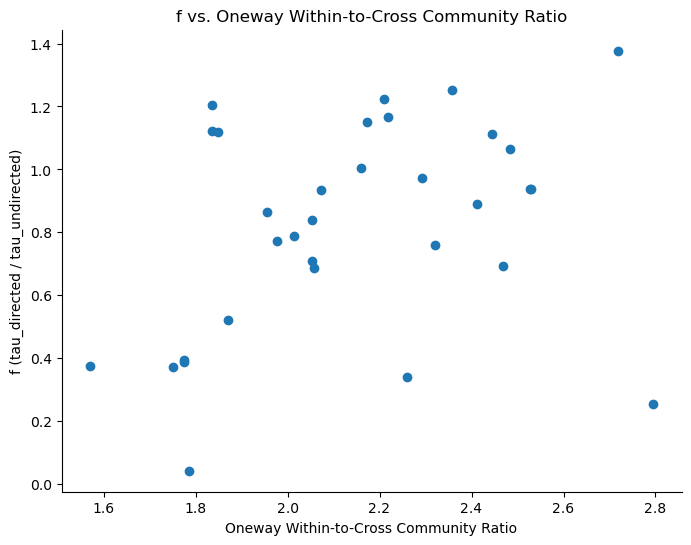

In [124]:
# Plot f vs. oneway_within_to_cross_ratio
fig, axes = plt.subplots(figsize=(8,6))

axes.scatter(df['oneway_within_to_cross_ratio'], df['f'])
axes.set_xlabel('Oneway Within-to-Cross Community Ratio')
axes.set_ylabel('f (tau_directed / tau_undirected)')
axes.set_title('f vs. Oneway Within-to-Cross Community Ratio')

sns.despine()

In [127]:
# Fit a regression to f vs oneway_within_to_cross_ratio
ols_model = sm.OLS(df['f'], sm.add_constant(df['oneway_within_to_cross_ratio']), missing='drop')
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      f   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.282
Date:                Thu, 18 Dec 2025   Prob (F-statistic):             0.0472
Time:                        11:29:45   Log-Likelihood:                -7.9893
No. Observations:                  32   AIC:                             19.98
Df Residuals:                      30   BIC:                             22.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           